# Stations network (Winter 2018, weekday)


In [204]:
%matplotlib inline 
#%matplotlib inline notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplleaflet
import pandas as pd
import numpy as np
import json
import math
from matplotlib import cm

import networkx as nx
import matplotlib.pyplot as plt

#import os

#os.environ['PROJ_LIB'] = r'C:\Users\pgsze\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'

from mpl_toolkits.basemap import Basemap

# Import, and set to log to the console.  (See the console which is running
# Jupyter notebook for logging about HTTP requests.)
#import tilemapbase
#tilemapbase.start_logging()

In [205]:
###
subs_df = pd.read_pickle('../data/pickledDFs/subs_df-NYC_Winter_2018.pkl')
stations_info_df = pd.read_pickle('../data/pickledDFs/stations_info_df-NYC_Winter_2018.pkl')
subs_trips_df = pd.read_pickle('../data/pickledDFs/subs_trips_df-NYC_Winter_2018.pkl')
###

In [206]:
subs_df[subs_df['start station latitude']>41]

Empty DataFrame
Columns: [tripduration, starttime, stoptime, start station id, start station name, start station latitude, start station longitude, end station id, end station name, end station latitude, end station longitude, bikeid, usertype, birth year, gender]
Index: []

In [207]:
#Number of weekend days and weekday days for Jan - March 2018
#num_WE = 25
#num_WD = 31+28+31-num_WE #Note I'm not subtracting holidays here, maybe later...

In [208]:
weekday_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] != 'Weekend'].copy()
weekend_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] == 'Weekend'].copy()

In [209]:
#Need to filter out stations in stations_info_df that do not appear in weekend_subs_trips
station_drops = []
WD_unique = np.unique(np.concatenate((weekday_subs_trips_df['start station id'].unique(),weekday_subs_trips_df['end station id'].unique())))

for ind in stations_info_df.index:
    if not (ind in WD_unique):
        station_drops.append(ind)
        
print(station_drops)

stations_info_df.drop(station_drops,inplace=True)
len(stations_info_df) == len(WD_unique)

[]


True

In [210]:
weekday_subs_trips_df.head()

tripduration               starttime                stoptime  \
0           970 2018-01-01 13:50:57.434 2018-01-01 14:07:08.186   
1           723 2018-01-01 15:33:30.182 2018-01-01 15:45:33.341   
2           496 2018-01-01 15:39:18.337 2018-01-01 15:47:35.172   
3           306 2018-01-01 15:40:13.372 2018-01-01 15:45:20.191   
4           306 2018-01-01 18:14:51.568 2018-01-01 18:19:57.642   

   start station id  end station id  bikeid    usertype  birth year  gender  \
0                72             505   31956  Subscriber        1992       1   
1                72            3255   32536  Subscriber        1969       1   
2                72             525   16069  Subscriber        1956       1   
3                72             447   31781  Subscriber        1974       1   
4                72            3356   30319  Subscriber        1992       1   

   start_day  stop_day  pickup_hour  dropoff_hour  age       Trip_Type  \
0          0         0           13            14   26  Daytime Errand   
1          0         0           15            15   49  Daytime Errand   
2          0         0           15            15   62  Daytime Errand   
3          0         0           15            15   44  Daytime Errand   
4          0         0           18            18   26        Commuter   

  start_end_station  
0         (72, 505)  
1        (72, 3255)  
2         (72, 525)  
3         (72, 447)  
4        (72, 3356)

In [322]:
edge_list_ser = weekday_subs_trips_df.groupby('start_end_station').count()['bikeid']
edge_list_ser = edge_list_ser[edge_list_ser > 10]
len(edge_list_ser)

31586

In [323]:
G = nx.Graph()

In [324]:
w_edge_list = [(i[0],i[1],edge_list_ser[i]) for i in edge_list_ser.index]

In [325]:
G.add_weighted_edges_from(w_edge_list,weight='num_trips')

In [326]:
num_out_df = weekday_subs_trips_df.groupby('start station id').count()['bikeid']
num_in_df = weekday_subs_trips_df.groupby('end station id').count()['bikeid']

tot_df = num_in_df+num_out_df

tot_df.head()

72     7349.0
79     6021.0
82     2268.0
83     3405.0
119    1161.0
Name: bikeid, dtype: float64

In [327]:
for node in G.nodes():
    G.nodes[node]['Location']= (stations_info_df.loc[node]['lon'],stations_info_df.loc[node]['lat'])
    G.nodes[node]['TMB_loc']= tilemapbase.project(nx.get_node_attributes(G,'Location')[node][0],nx.get_node_attributes(G,'Location')[node][1])
    G.nodes[node]['usage']= tot_df.loc[node]

In [334]:
btwn_centrality_ser = pd.Series(nx.betweenness_centrality(G,normalized=True, endpoints=False))
close_centrality_ser = pd.Series(nx.closeness_centrality(G,wf_improved=True))

In [329]:
import tilemapbase
tilemapbase.start_logging()

In [330]:
NYC_center = (-74.006,40.713)
NYC_center_moves = []

for num in range(5):
    NYC_center_moves.append(tuple([NYC_center[0]+num*.001,NYC_center[1]+num*.001]))

extent = tilemapbase.Extent.from_lonlat(-74.03,-73.91, 40.65, 40.81)

#extent = extent.to_aspect(1)
extent

Extent((0.29436111111111113,0.3756243319633231)->(0.2946944444444445,0.37621083107798253) projected as normal)

In [331]:
t = tilemapbase.tiles.Carto_Light

## Degree as node color

the degree node v is the number of edges connected to it

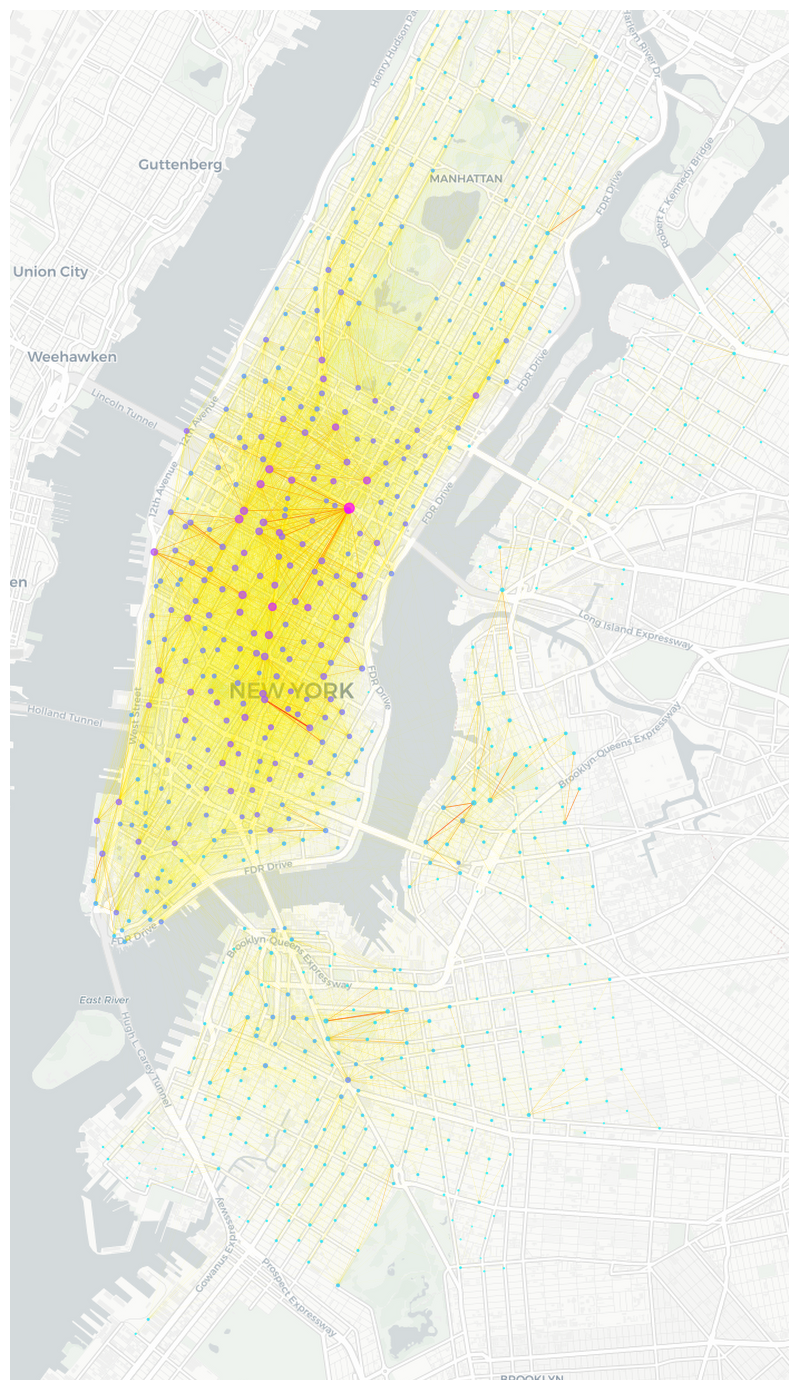

In [332]:
#node color = degree
fig, ax = plt.subplots(figsize=(14,14), dpi=100)
    
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)


node_color = [G.degree(v) for v in G]
#node_color = [btwn_centrality_ser.loc[node]/btwn_centrality_ser.max() for node in G.nodes()]
#node_color = [close_centrality_ser.loc[node]/close_centrality_ser.max() for node in G.nodes()]
node_size = [0.001*nx.get_node_attributes(G, 'usage')[v] for v in G]
#pos = nx.get_node_attributes(G,'Location')
pos=nx.get_node_attributes(G,'TMB_loc')
edge_width = [0.0005*G[u][v]['num_trips'] for u,v in G.edges()]

nx.draw_networkx(G, pos, node_size=node_size, 
                 node_color=node_color, alpha=.7, with_labels=False, 
                 width=edge_width, #edge_color='.4', 
                 cmap=plt.cm.cool,
                 vmin=sorted(node_color)[0],vmax = sorted(node_color)[-1],
                 edge_color = list(nx.get_edge_attributes(G,'num_trips').values()),
                 edge_cmap = plt.cm.autumn_r,
                 edge_vmin = sorted(nx.get_edge_attributes(G,'num_trips').values())[0], edge_vmax = sorted(nx.get_edge_attributes(G,'num_trips').values())[-1])

plt.axis('off')
plt.tight_layout();

## Betweenness centrality as node color 
betweenness centrality of node v is the sum over all pairs of nodes s, t in the graph of the percentage of shortest paths between s, t that contain node v

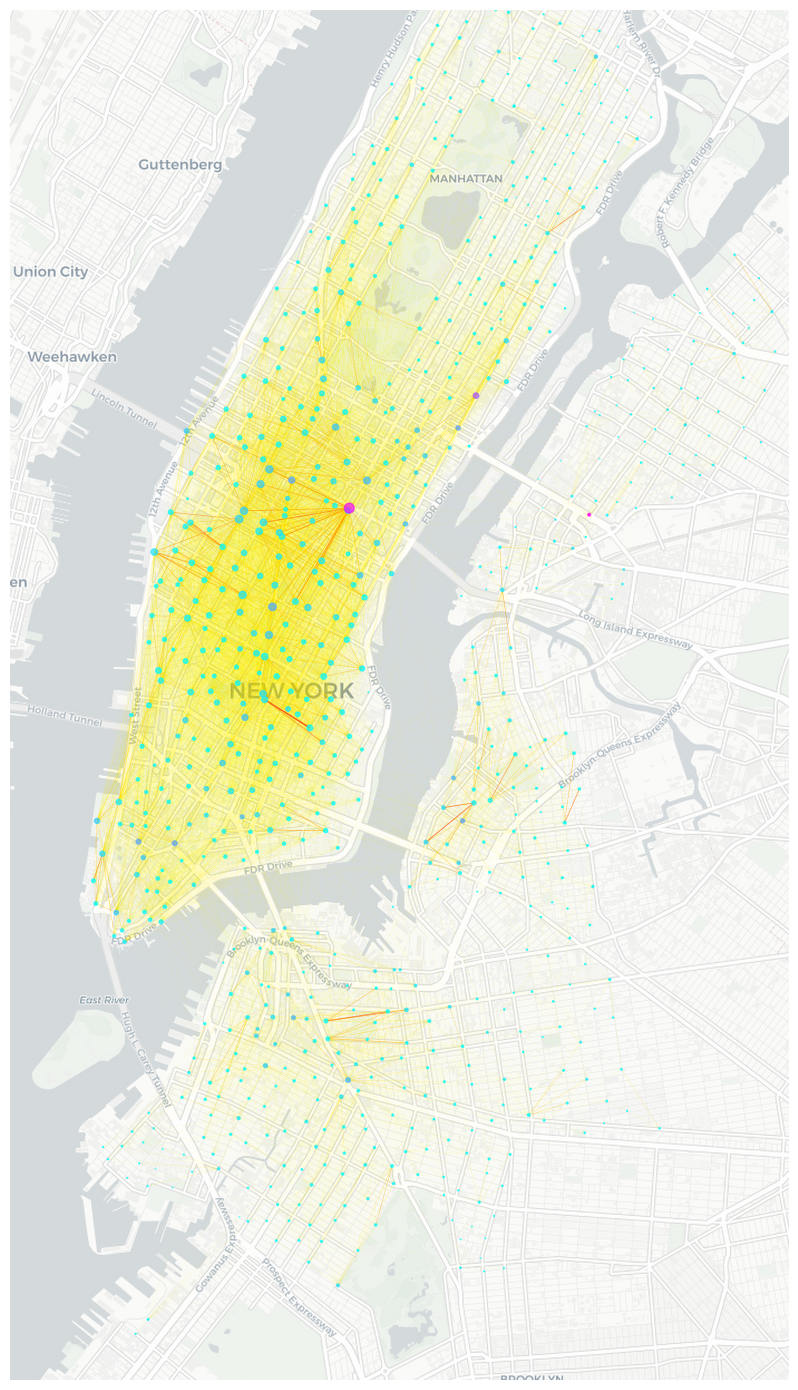

In [335]:
#node color = degree
fig, ax = plt.subplots(figsize=(14,14), dpi=100)
    
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)


#node_color = [G.degree(v) for v in G]
btwn_max = btwn_centrality_ser.max()
node_color = [btwn_centrality_ser.loc[node]/btwn_max for node in G.nodes()]
#node_color = [close_centrality_ser.loc[node]/close_centrality_ser.max() for node in G.nodes()]
node_size = [0.001*nx.get_node_attributes(G, 'usage')[v] for v in G]
#pos = nx.get_node_attributes(G,'Location')
pos=nx.get_node_attributes(G,'TMB_loc')
edge_width = [0.0005*G[u][v]['num_trips'] for u,v in G.edges()]

nx.draw_networkx(G, pos, node_size=node_size, 
                 node_color=node_color, alpha=.7, with_labels=False, 
                 width=edge_width, #edge_color='.4', 
                 cmap=plt.cm.cool,
                 vmin=sorted(node_color)[0],vmax = sorted(node_color)[-1],
                 edge_color = list(nx.get_edge_attributes(G,'num_trips').values()),
                 edge_cmap = plt.cm.autumn_r,
                 edge_vmin = sorted(nx.get_edge_attributes(G,'num_trips').values())[0], edge_vmax = sorted(nx.get_edge_attributes(G,'num_trips').values())[-1])

plt.axis('off')
plt.tight_layout();

## Closeness centrality as node color

closeness centrality of a node v is defined as the inverse of the sum of the shorest path distances between node v and every other connected node in the graph

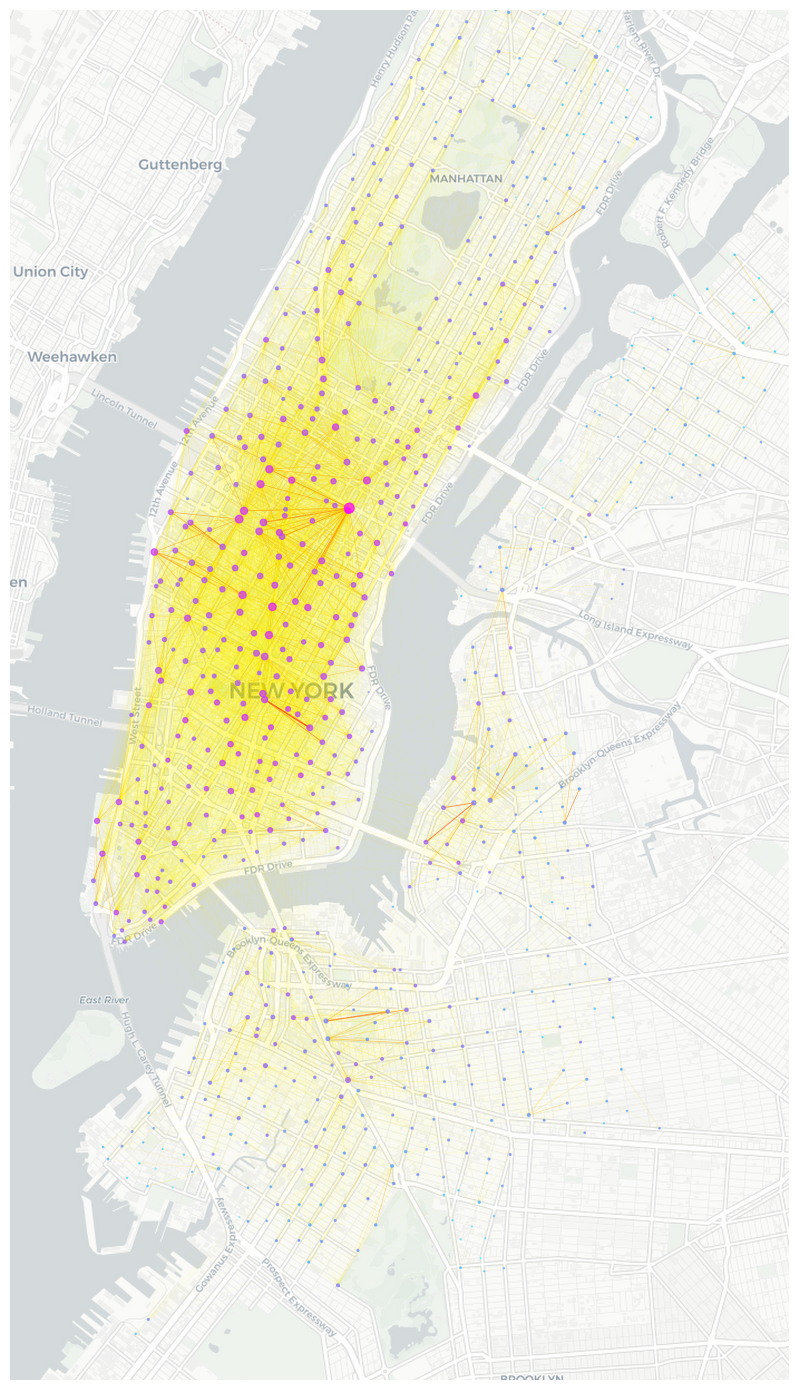

In [336]:
#node color = degree
fig, ax = plt.subplots(figsize=(14,14), dpi=100)
    
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)


#node_color = [G.degree(v) for v in G]
#node_color = [btwn_centrality_ser.loc[node]/btwn_centrality_ser.max() for node in G.nodes()]
close_max=close_centrality_ser.max()
node_color = [close_centrality_ser.loc[node]/close_max for node in G.nodes()]
node_size = [0.001*nx.get_node_attributes(G, 'usage')[v] for v in G]
#pos = nx.get_node_attributes(G,'Location')
pos=nx.get_node_attributes(G,'TMB_loc')
edge_width = [0.0005*G[u][v]['num_trips'] for u,v in G.edges()]

nx.draw_networkx(G, pos, node_size=node_size, 
                 node_color=node_color, alpha=.7, with_labels=False, 
                 width=edge_width, #edge_color='.4', 
                 cmap=plt.cm.cool,
                 #there is one node with CC=zero, which I am dropping in v_range
                 vmin=sorted(node_color)[1],vmax = sorted(node_color)[-1],
                 edge_color = list(nx.get_edge_attributes(G,'num_trips').values()),
                 edge_cmap = plt.cm.autumn_r,
                 edge_vmin = sorted(nx.get_edge_attributes(G,'num_trips').values())[0], edge_vmax = sorted(nx.get_edge_attributes(G,'num_trips').values())[-1])

plt.axis('off')
plt.tight_layout();

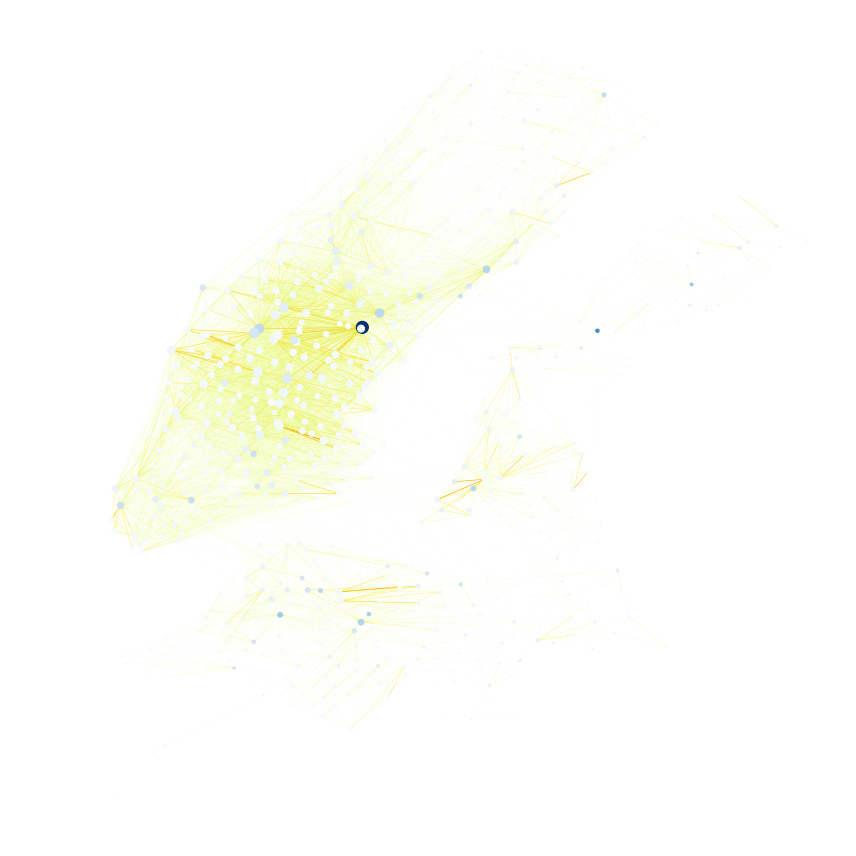

In [282]:
plt.figure(figsize=(12,12))

#node_color = [G.degree(v) for v in G]
node_color = [btwn_centrality_ser.loc[node]/btwn_centrality_ser.max() for node in G.nodes()]
node_size = [0.003*nx.get_node_attributes(G, 'usage')[v] for v in G]
pos = nx.get_node_attributes(G,'Location')
edge_width = [0.0005*G[u][v]['num_trips'] for u,v in G.edges()]

nx.draw_networkx(G, pos, node_size=node_size, 
                 node_color=node_color, alpha=1, with_labels=False, 
                 width=edge_width, #edge_color='.4', 
                 cmap=plt.cm.Blues,
                 vmin=sorted(node_color)[0],vmax = sorted(node_color)[-1],
                 edge_color = list(nx.get_edge_attributes(G,'num_trips').values()),
                 edge_cmap = plt.cm.Wistia,
                 edge_vmin = sorted(nx.get_edge_attributes(G,'num_trips').values())[0], edge_vmax = sorted(nx.get_edge_attributes(G,'num_trips').values())[-1])

plt.axis('off')
plt.tight_layout();

In [226]:
num_out_df = weekday_subs_trips_df.groupby('start station id').count()['bikeid']
num_in_df = weekday_subs_trips_df.groupby('end station id').count()['bikeid']

tot_df = num_in_df+num_out_df

tot_df.head()

72     7349.0
79     6021.0
82     2268.0
83     3405.0
119    1161.0
Name: bikeid, dtype: float64

In [228]:
for node in G.nodes():
    G.nodes[node]['usage']= tot_df.loc[node]
    

In [286]:
btwn_centrality_ser = pd.Series(nx.betweenness_centrality(G,normalized=True, endpoints=False))
close_centrality_ser = pd.Series(nx.closeness_centrality(G,wf_improved=True))

In [302]:
btwn_centrality_ser.sort_values(ascending=False)

519     0.160130
3129    0.101697
3593    0.060872
3409    0.057563
274     0.054501
3429    0.048230
390     0.046564
3141    0.046471
539     0.046179
359     0.043445
490     0.041990
3507    0.038391
3243    0.036707
387     0.036384
251     0.034907
3002    0.033403
3223    0.029671
3110    0.028528
354     0.028443
323     0.028251
3382    0.026804
3255    0.026450
392     0.026357
313     0.025775
412     0.024231
467     0.023674
514     0.023409
3398    0.022278
505     0.019527
3516    0.019438
          ...   
400     0.000000
3348    0.000000
144     0.000000
3604    0.000000
216     0.000000
3668    0.000000
3122    0.000000
3493    0.000000
3326    0.000000
3490    0.000000
3477    0.000000
3401    0.000000
3394    0.000000
3491    0.000000
3352    0.000000
3342    0.000000
3340    0.000000
3337    0.000000
3495    0.000000
3123    0.000000
3338    0.000000
3327    0.000000
3583    0.000000
3309    0.000000
3441    0.000000
3395    0.000000
3239    0.000000
3325    0.0000

In [277]:
node_color = [btwn_centrality_ser.loc[node] for node in G.nodes()]

In [287]:
node_color = [close_centrality_ser.loc[node] for node in G.nodes()]

In [296]:
close_centrality_ser.sort_values(ascending=True).head(100)

3239    0.000000
3525    0.130767
3528    0.130767
3530    0.130767
3532    0.130767
3573    0.148179
3604    0.148638
3526    0.150439
3654    0.151899
3043    0.153945
3477    0.157034
3515    0.157757
3524    0.157757
3560    0.171103
3595    0.172002
3561    0.172745
3579    0.173119
3578    0.173119
3572    0.173955
3599    0.174588
3340    0.175225
3337    0.175225
3342    0.175225
3394    0.175225
3352    0.175225
3326    0.175225
3401    0.175225
3505    0.176298
3522    0.176557
3512    0.179016
          ...   
3586    0.205950
3597    0.205950
3588    0.205950
3577    0.206068
3575    0.206186
3065    0.206245
3653    0.206363
3602    0.206363
3555    0.206422
3603    0.206600
3589    0.206778
3591    0.206956
3055    0.207016
2005    0.207733
3568    0.207733
3059    0.207733
3058    0.207733
3565    0.207973
3120    0.208394
3494    0.208575
3584    0.209364
3395    0.209913
3061    0.210650
3349    0.210959
3607    0.211206
3609    0.211330
3543    0.211392
3503    0.2124

In [291]:
btwn_centrality_ser.sort_values(ascending=False).head()

519     0.160130
3129    0.101697
3593    0.060872
3409    0.057563
274     0.054501
dtype: float64